# Testing a simple DNN as a replacement for the BDT

This notebook requires an install of pytorch in addition to the libraries used throughout the rest of the notebook

In [1]:
%load_ext autoreload
%autoreload 2

import os,sys
import uproot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from scipy.special import logit
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split

from array import array
from math import floor, log10
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

print ('Success')

### Some root paths used by different users/devices
#     root_dir = "../../For_David/" for the default root directory used by David
#     root_dir = "/exp/uboone/data/users/jbateman/workdir/HPS_uboone_analysis/" # Filepath used on the FNAL cluster.
#     root_dir = "/Users/user/PhD/HPS_uboone_analysis/" # A filepath used for local running.
root_dir = "/Users/user/PhD/HPS_uboone_analysis/"
root_dir_fix = root_dir


Success


### Standard pkl inport functions

In [108]:
def Get_ratios_trained(df):
    """
    Given a dataframe with variable \"is_trained\", will print the numbers of events with zero, number of events where it is one and the fraction of zeros.
    """
    num_zeros = len(df.query('is_trained==0'))
    num_ones = len(df.query('is_trained==1'))
    print(f"Zeros: {num_zeros}")
    print(f"Ones: {num_ones}")
    print(f"Fraction of zeros: {num_zeros/(num_zeros+num_ones)}")
    
def sci_notation(num, decimal_digits=0, precision=None, exponent=None):
    """
    Returns a string representation of the scientific
    notation of the given number formatted for use with
    LaTeX or Mathtext, with specified number of significant
    decimal digits and precision (number of decimal digits
    to show). The exponent to be used can also be specified
    explicitly.
    """
    if exponent is None:
        exponent = int(floor(log10(abs(num))))
    coeff = round(num / float(10**exponent), decimal_digits)
    if precision is None:
        precision = decimal_digits

    return r"${0:.{1}f}\times10^{{{{".format(coeff,precision)+"{0:d}".format(exponent)+"}}$"

def match_RSE_indices(pkl_data, uproot_file,columns=[0,1,2]):
    """
    This function matches events in the pkl file to the uproot file, using the run, subrun and event number.
    It returns the indices of the uproot file that match the pkl file, used to retrive the time of 
    flight values. 
    """
    
    test_run = pkl_data['run_ls'].to_numpy()
    test_subrun = pkl_data['sub_ls'].to_numpy()
    test_event = pkl_data['evt_ls'].to_numpy()

    keys = uproot_file.keys()
    data = uproot_file[keys[0]]
    keys = data.keys()
    runs = data[keys[columns[0]]].array()
    subruns = data[keys[columns[1]]].array()
    event = data[keys[columns[2]]].array()

    indices = []
    for i, run in enumerate(test_run):
        run_args = np.where(runs==run)
        subrun_args = np.where(subruns==test_subrun[i])
        event_arg = np.where(event==test_event[i])
        shared_run_sub_arg = np.intersect1d(run_args, subrun_args)
        shared_arg = np.intersect1d(shared_run_sub_arg, event_arg)
        indices.append(shared_arg[0])
    return indices

def New_loader(Run, mass, nshr, KDIF_KDAR_str, bool_full_sample=True, get_tof=False, for_david=True, testing_new_flux = False, update_KDAR_scaling = False):
    """
    New function to load the .pkl files as dataframes. Mostly taken directly from Aditya's code.
    get_tof is a boolean that determines whether to load the time of flight values from the root file.
    """
    #Constants for normalisation factors
    
    mc_pot_fhc = 2.33652e+21 # Need to update this when using new flux
    mc_pot_rhc = 1.98937e+21 # Need to update this when using new flux
    dirt_pot_fhc = 1.42143e+21
    dirt_pot_rhc = 1.03226e+21
    OnBeam_EA9CNT_wcut_fhc = 5268051.0
    OnBeam_EA9CNT_wcut_rhc = 10363728.0
    OffBeam_EXT_NUMIwin_FEMBeamTriggerAlgo_fhc = 9199232.74
    OffBeam_EXT_NUMIwin_FEMBeamTriggerAlgo_rhc = 32878305.25
    scale_ext_fhc = OnBeam_EA9CNT_wcut_fhc/OffBeam_EXT_NUMIwin_FEMBeamTriggerAlgo_fhc
    scale_ext_rhc = OnBeam_EA9CNT_wcut_rhc/OffBeam_EXT_NUMIwin_FEMBeamTriggerAlgo_rhc
    scale_ext_fhc = scale_ext_fhc*.98
    scale_ext_rhc = scale_ext_rhc*.98
    OnBeam_tortgt_wcut_fhc = 2.002e20
    OnBeam_tortgt_wcut_rhc = 5.009e20
    scale_nu_fhc = OnBeam_tortgt_wcut_fhc/mc_pot_fhc
    scale_nu_rhc = OnBeam_tortgt_wcut_rhc/mc_pot_rhc
    scale_dirt_fhc = OnBeam_tortgt_wcut_fhc/dirt_pot_fhc
    scale_dirt_rhc = OnBeam_tortgt_wcut_rhc/dirt_pot_rhc
    scale_dirt_fhc = scale_dirt_fhc*0.75
    scale_dirt_rhc = scale_dirt_rhc*0.35

    if Run == 'Run1':
        fhc_rhc_str = 'fhc'
        OnBeam_tortgt_wcut = OnBeam_tortgt_wcut_fhc
        scale_nu = scale_nu_fhc
        scale_dirt = scale_dirt_fhc
        scale_ext = scale_ext_fhc
    elif Run == 'Run3':
        if testing_new_flux:    
            print('Using new flux overlay')
            # # Params for new flux files
            mc_pot_rhc = 2.644072435807561e+21 # PoT for new flux, old flux val = 1.98937e+21
            scale_nu_rhc = OnBeam_tortgt_wcut_rhc/mc_pot_rhc
            # # Not touching these for now. Correspond to the EXT scaling, which is a separate file we haven't changed.
            # OnBeam_EA9CNT_wcut_rhc = 1795139.0 # for new flux, old val = 10363728.0
            # OffBeam_EXT_NUMIwin_FEMBeamTriggerAlgo_rhc = 5884692.975000 # for new flux, old val = 32878305.25
            # scale_ext_rhc = OnBeam_EA9CNT_wcut_rhc/OffBeam_EXT_NUMIwin_FEMBeamTriggerAlgo_rhc
            
            

        fhc_rhc_str = 'rhc'
        OnBeam_tortgt_wcut = OnBeam_tortgt_wcut_rhc
        scale_nu = scale_nu_rhc
        scale_dirt = scale_dirt_rhc
        scale_ext = scale_ext_rhc
    
    main_input_dir = root_dir+"/BDT_inputs_pkl/"
    
    ### DATA ###
    if bool_full_sample == True:
        print ('No data')
        df_data = pd.read_pickle(main_input_dir+'AllVar_Selected_'+Run+'_NuMI_opendata_'+nshr+'_NEW.pkl')
        df_data ['pred'] = 1.0
    else:
        df_data = pd.read_pickle(main_input_dir+'AllVar_Selected_'+Run+'_NuMI_Opendata_'+KDIF_KDAR_str+'_'+mass+'_'+nshr+'_PPFX_pred_NEW.pkl')
    
    #### SIG ####
    if bool_full_sample == True: print ('No signal')
    else:
        df_sig = pd.read_pickle(main_input_dir+'AllVar_Selected_'+Run+'_NuMI_Signal_'+KDIF_KDAR_str+'_'+mass+'_'+nshr+'_PPFX_pred_NEW.pkl')
        if get_tof==True:
            tof_file = f"tof_{fhc_rhc_str}_{mass}.root"

            with uproot.open(root_dir+"TOF_input_root/"+tof_file) as tof_data:
                indices = match_RSE_indices(df_sig, tof_data)
                keys = tof_data.keys()
                tof_data = tof_data[keys[0]]
                tof = tof_data['proper_tof'].array()[indices].to_numpy()

            df_sig['tof'] = tof
        frac_sig_test_sample = len(df_sig.query('is_trained == 0'))/len(df_sig)
        df_sig['frac_test_sample'] = frac_sig_test_sample #Should be 0.4
        df_sig = df_sig.query('is_trained==0') #Only taking testing events!
        
        if update_KDAR_scaling:
            print('Updating KDAR scaling for signal')

            if Run == 'Run1':
                df_sig['KDAR_scale'] = df_sig['KDAR_scale'].astype(float)
                df_sig.loc[df_sig['KDAR_scale'] == 8.0, 'KDAR_scale'] = 0.085/0.016
            elif Run == 'Run3':
                df_sig.loc[df_sig['KDAR_scale'] == 8.6, 'KDAR_scale'] = 0.085/0.016

            
        df_sig.eval('scale_factor_ls = (1/frac_test_sample)*KDAR_scale*'+str(OnBeam_tortgt_wcut)+'/test_sample_POT_ls',inplace=True)

    #### OVL ####
    if testing_new_flux and Run == 'Run3':
        loc_BDT_input = '/exp/uboone/data/users/jbateman/workdir/HPS_uboone_analysis/NewFlux/BDT_input_pkl/'
        # df_ovl = pd.read_pickle(main_input_dir+'AllVar_Selected_'+Run+'_NuMI_Overlay_'+KDIF_KDAR_str+'_'+mass+'_'+nshr+'_PPFX_pred_NEW.pkl') # Old overlay files
        df_ovl = pd.read_pickle(loc_BDT_input + f'AllVar_Selected_{Run}_NuMI_Overlay_{KDIF_KDAR_str}_{mass}_MeV_{nshr}_Weights_Updated_Flux_pred.pkl') # New flux overlay
        frac_ovl_test_sample = len(df_ovl.query('is_trained == 0'))/len(df_ovl) #Should be 0.4
        df_ovl['frac_test_sample'] = frac_ovl_test_sample
        df_ovl = df_ovl.query('is_trained==0')
        df_ovl.eval('scale_factor_ls = (1/frac_test_sample)*KDAR_scale*'+str(scale_nu),inplace=True)
        df_ovl['is_good_genie'] = 1
        df_ovl['is_good_ppfx'] = 1
        df_ovl['is_good_reint'] = 1

        df_ovl.loc[df_ovl['inf_weight_genie'] == "yes", 'is_good_genie'] = 0
        df_ovl.loc[df_ovl['zero_weight_genie'] == "yes", 'is_good_genie'] = 0
        df_ovl.loc[df_ovl['ones_weight_genie'] == "yes", 'is_good_genie'] = 0
        df_ovl.loc[df_ovl['thsnd_weight_genie'] == "yes", 'is_good_genie'] = 0
        
        df_ovl.loc[df_ovl['inf_weight_ppfx'] == "yes", 'is_good_ppfx'] = 0
        df_ovl.loc[df_ovl['zero_weight_ppfx'] == "yes", 'is_good_ppfx'] = 0
        df_ovl.loc[df_ovl['ones_weight_ppfx'] == "yes", 'is_good_ppfx'] = 0
        df_ovl.loc[df_ovl['thsnd_weight_ppfx'] == "yes", 'is_good_ppfx'] = 0
        
        df_ovl.loc[df_ovl['inf_weight_reint'] == "yes", 'is_good_reint'] = 0
        df_ovl.loc[df_ovl['zero_weight_reint'] == "yes", 'is_good_reint'] = 0
        df_ovl.loc[df_ovl['ones_weight_reint'] == "yes", 'is_good_reint'] = 0
        df_ovl.loc[df_ovl['thsnd_weight_reint'] == "yes", 'is_good_reint'] = 0
    
    
    else:
        if bool_full_sample == True:
            df_ovl = pd.read_pickle(main_input_dir+'AllVar_Selected_'+Run+'_NuMI_Overlay_'+nshr+'_WEIGHTS_NEW.pkl')
            df_ovl.eval('scale_factor_ls = KDAR_scale*'+str(scale_nu),inplace=True)
            df_ovl ['pred'] = 1.0
        else:
            df_ovl = pd.read_pickle(main_input_dir+'AllVar_Selected_'+Run+'_NuMI_Overlay_'+KDIF_KDAR_str+'_'+mass+'_'+nshr+'_PPFX_pred_NEW.pkl')
            frac_ovl_test_sample = len(df_ovl.query('is_trained == 0'))/len(df_ovl) #Should be 0.4
            df_ovl['frac_test_sample'] = frac_ovl_test_sample
            df_ovl = df_ovl.query('is_trained==0')
            df_ovl.eval('scale_factor_ls = (1/frac_test_sample)*KDAR_scale*'+str(scale_nu),inplace=True)

        df_ovl['is_good_genie'] = 1
        df_ovl['is_good_ppfx'] = 1
        df_ovl['is_good_reint'] = 1
        
        df_ovl['thsnd_weight_genie'] = (['yes' if all(a == 1000 for a in i) else 'no' for i in df_ovl['weightsGenie']])
        df_ovl['thsnd_weight_ppfx'] = (['yes' if all(a == 1000 for a in i) else 'no' for i in df_ovl['weightsPPFX']])
        df_ovl['thsnd_weight_reint'] = (['yes' if all(a == 1000 for a in i) else 'no' for i in df_ovl['weightsReint']])
        
        df_ovl.loc[df_ovl['inf_weight_genie'] == "yes", 'is_good_genie'] = 0
        df_ovl.loc[df_ovl['zero_weight_genie'] == "yes", 'is_good_genie'] = 0
        df_ovl.loc[df_ovl['ones_weight_genie'] == "yes", 'is_good_genie'] = 0
        df_ovl.loc[df_ovl['thsnd_weight_genie'] == "yes", 'is_good_genie'] = 0
        
        df_ovl.loc[df_ovl['inf_weight_ppfx'] == "yes", 'is_good_ppfx'] = 0
        df_ovl.loc[df_ovl['zero_weight_ppfx'] == "yes", 'is_good_ppfx'] = 0
        df_ovl.loc[df_ovl['ones_weight_ppfx'] == "yes", 'is_good_ppfx'] = 0
        df_ovl.loc[df_ovl['thsnd_weight_ppfx'] == "yes", 'is_good_ppfx'] = 0
        
        df_ovl.loc[df_ovl['inf_weight_reint'] == "yes", 'is_good_reint'] = 0
        df_ovl.loc[df_ovl['zero_weight_reint'] == "yes", 'is_good_reint'] = 0
        df_ovl.loc[df_ovl['ones_weight_reint'] == "yes", 'is_good_reint'] = 0
        df_ovl.loc[df_ovl['thsnd_weight_reint'] == "yes", 'is_good_reint'] = 0

    ### DIRT ###
    if bool_full_sample == True:
        df_dirt = pd.read_pickle(main_input_dir+'AllVar_Selected_'+Run+'_NuMI_Dirt_'+nshr+'_WEIGHTS_NEW.pkl')
        df_dirt.eval('scale_factor_ls = KDAR_scale*'+str(scale_dirt),inplace=True)
        df_dirt ['pred'] = 1.0
    else:
        df_dirt = pd.read_pickle(main_input_dir+'AllVar_Selected_'+Run+'_NuMI_Dirt_'+KDIF_KDAR_str+'_'+mass+'_'+nshr+'_PPFX_pred_NEW.pkl')
        frac_dirt_test_sample = len(df_dirt.query('is_trained == 0'))/len(df_dirt)
        df_dirt['frac_test_sample'] = frac_dirt_test_sample

        df_dirt = df_dirt.query('is_trained==0')
        df_dirt.eval('scale_factor_ls = (1/frac_test_sample)*KDAR_scale*'+str(scale_dirt),inplace=True)
    
    df_dirt['is_good'] = 0
    
    #### EXT ####
    if bool_full_sample == True:
        df_ext = pd.read_pickle(main_input_dir+'AllVar_Selected_'+Run+'_NuMI_Ext_'+nshr+'_WEIGHTS_NEW.pkl')
        df_ext.eval('scale_factor_ls = KDAR_scale*'+str(scale_ext),inplace=True)
        df_ext ['pred'] = 1.0
    else:
        df_ext = pd.read_pickle(main_input_dir+'AllVar_Selected_'+Run+'_NuMI_Ext_'+KDIF_KDAR_str+'_'+mass+'_'+nshr+'_PPFX_pred_NEW.pkl')
        frac_ext_test_sample = len(df_ext.query('is_trained == 0'))/len(df_ext)
        df_ext['frac_test_sample'] = frac_ext_test_sample

        df_ext = df_ext.query('is_trained==0')
        df_ext.eval('scale_factor_ls = (1/frac_test_sample)*KDAR_scale*'+str(scale_ext),inplace=True)
   
    #### Detsys ####
    if mass == '125' or mass == '130' or mass == '135' or mass == '140' or mass == '145':
        detsys_mass = '150'
        print("Loading 150 MeV detsys samples")
    else: detsys_mass = mass
    
    # detsys_sig_input_dir = './Final_detector_systematics_SIGNAL/'+detsys_mass+'_MeV/'
    # detsys_bkg_input_dir = './Final_detector_systematics_BACKGROUND/'+detsys_mass+'_MeV/'
    detsys_sig_input_dir = root_dir+'/Final_detector_systematics_SIGNAL/'+detsys_mass+'_MeV/'
    detsys_bkg_input_dir = root_dir+'/Final_detector_systematics_BACKGROUND/'+detsys_mass+'_MeV/'

    KDIF_KDAR_str_lower = KDIF_KDAR_str.lower()
    df_sig_detsys = pd.read_pickle(detsys_sig_input_dir + 'Signal_' + fhc_rhc_str + '_' + detsys_mass + '_MeV_' + nshr + '_' + KDIF_KDAR_str_lower +'.pkl')
    df_ovl_detsys = pd.read_pickle(detsys_bkg_input_dir + "bkg_" + fhc_rhc_str + '_' + detsys_mass + '_MeV_' + nshr + '_' + KDIF_KDAR_str_lower +'.pkl')
    
    sig_detsys_labels = ["CV",
        "ly_atten",
        "ly_down",
        "ly_rayleigh",
        "recomb",
        "sce",
        "wiremod_anglexz",
        "wiremod_angleyz",
        "wiremod_dEdx",
        "wiremod_x",
        "wiremod_yz",]

    if update_KDAR_scaling:
        for label in sig_detsys_labels:
            suffix = '_'+label
            
            # print(f'Updating KDAR scaling for sig detsys {label}')
            if Run == 'Run1':
                df_sig_detsys['KDAR_scale'+suffix] = df_sig_detsys['KDAR_scale'+suffix].astype(float)
                df_sig_detsys.loc[df_sig_detsys['KDAR_scale'+suffix] == 8.0, 'KDAR_scale'+suffix] = 0.085/0.016
            elif Run == 'Run3':
                df_sig_detsys.loc[df_sig_detsys['KDAR_scale'+suffix] == 8.6, 'KDAR_scale'+suffix] = 0.085/0.016

    ovl_detsys_labels = [
        "CV",
        "LYAttenuation",
        "LYDown",
        "LYRayleigh",
        "Recomb2",
        "SCE",
        "WireModThetaXZ",
        "WireModThetaYZ",
        "WireModdEdX",
        "WireModX",
        "WireModYZ",
            ]

    if testing_new_flux:
        # print('Updating KDAR scaling for overlay detsys')
        for label in ovl_detsys_labels:
            suffix = '_'+label
            df_ovl_detsys['KDAR_scale'+suffix]  *= 0.71 # +- 0.04 This is the average scale factor from the old to new flux for this sample. Calculated in BDT_pkl_gen/create_pkls_nb.ipynb
    
    
    if bool_full_sample == True: print ('NO LOGIT FOR SIGNAL..')
    else: df_sig['logit_pred'] = logit(df_sig['pred'])
    
    df_ovl['logit_pred'] = logit(df_ovl['pred'])
    df_dirt['logit_pred'] = logit(df_dirt['pred'])
    df_ext['logit_pred'] = logit(df_ext['pred'])
    df_data['logit_pred'] = logit(df_data['pred'])
    
    pred_column_sig = [col for col in df_sig_detsys if col.startswith('pred')]
    pred_column_ovl = [col for col in df_ovl_detsys if col.startswith('pred')]
    
    df_sig_detsys_copy = df_sig_detsys.copy()
    df_ovl_detsys_copy = df_ovl_detsys.copy()
    
    for pred in pred_column_sig:
        df_sig_detsys_copy['logit_'+pred] = logit(df_sig_detsys[pred])
    
    for pred in pred_column_ovl:
        df_ovl_detsys_copy['logit_'+pred] = logit(df_ovl_detsys[pred])

    print (f'SUCCESSFULLY LOADED THE PICKLE FILES {Run, mass, nshr, KDIF_KDAR_str}')
    
    if bool_full_sample == True:
        return df_ovl, df_dirt, df_ext, df_data, df_sig_detsys_copy, df_ovl_detsys_copy
    else:
        return df_sig, df_ovl, df_dirt, df_ext, df_data, df_sig_detsys_copy, df_ovl_detsys_copy
    

## Importing pkls

Note that the root path is defined in the first cell.

In [242]:
sample_dict = {}

root_dir = root_dir_fix

df_sig_dict, df_overlay_dict, df_dirt_dict, df_beamoff_dict, df_data_dict = {},{},{},{},{}
sig_detsys_dict, ov_detsys_dict = {}, {}

Run = "1"
get_TOF = False # Set to true to load time of flight values, used for the axion reweighting.
use_new_flux = False # Set to true to use the new (fixed) flux files. Currently only generated for Run3.
update_KDAR_scaling = True

HPS_masses = [150] # [100, 125, 135, 140, 145, 150, 200]
shr_arr = ["1shr"] # ["1shr", "2shr"]
K_arr = ["KDIF"] # ["KDIF", "KDAR"]

for HPS_mass in HPS_masses:
    for shr in shr_arr:
        for K in K_arr:
            name = f"{HPS_mass}_{shr}_{K}"
            
            df_sig_dict[name], df_overlay_dict[name], df_dirt_dict[name], df_beamoff_dict[name], df_data_dict[name], sig_detsys_dict[name], ov_detsys_dict[name] = New_loader('Run'+Run, str(HPS_mass), shr, K, bool_full_sample=False, get_tof=get_TOF, for_david=False, testing_new_flux=use_new_flux, update_KDAR_scaling=update_KDAR_scaling)

Updating KDAR scaling for signal


/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_92430/1718207215.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sig['KDAR_scale'] = df_sig['KDAR_scale'].astype(float)


SUCCESSFULLY LOADED THE PICKLE FILES ('Run1', '150', '1shr', 'KDIF')


In [243]:
theta_text_dict = {'100':5.36e-4, '125':5.5e-4, '130':5.54e-4, '135':5.58e-4, '140':5.63e-4, '145':5.68e-4, '150':5.73e-4, '200':6.58e-4} #Taken directly from Aditya's thesis

theta_dict={'100_1shr_KDIF': 0.000536, '100_1shr_KDAR': 0.000536, '100_2shr_KDIF': 0.000536, '100_2shr_KDAR': 0.000536, 
            '125_1shr_KDIF': 0.00055, '125_1shr_KDAR': 0.00055, '125_2shr_KDIF': 0.00055, '125_2shr_KDAR': 0.00055, 
            '130_1shr_KDIF': 0.000554, '130_1shr_KDAR': 0.000554, '130_2shr_KDIF': 0.000554, '130_2shr_KDAR': 0.000554, 
            '135_1shr_KDIF': 0.000558, '135_1shr_KDAR': 0.000558, '135_2shr_KDIF': 0.000558, '135_2shr_KDAR': 0.000558, 
            '140_1shr_KDIF': 0.000563, '140_1shr_KDAR': 0.000563, '140_2shr_KDIF': 0.000563, '140_2shr_KDAR': 0.000563, 
            '145_1shr_KDIF': 0.000568, '145_1shr_KDAR': 0.000568, '145_2shr_KDIF': 0.000568, '145_2shr_KDAR': 0.000568, 
            '150_1shr_KDIF': 0.000573, '150_1shr_KDAR': 0.000573, '150_2shr_KDIF': 0.000573, '150_2shr_KDAR': 0.000573, 
            '200_1shr_KDIF': 0.000658, '200_1shr_KDAR': 0.000658, '200_2shr_KDIF': 0.000658, '200_2shr_KDAR': 0.000658}


print("Default thetas are:")
print(theta_dict)
print()

#Calculating the scalings for the signal histograms required to get the limits Aditya originally quoted. 
theta_scaling, hist_scaling = {}, {}
limit_theta_power_1 = {}
paper_limits = {100:3.08e-4, 125:2.93e-4, 130:2.94e-4, 135:3.21e-4, 140:2.79e-4, 145:2.47e-4, 150:2.9e-4, 200:2.31e-4} #Limits given by Aditya
for HNL_mass in theta_dict:
    mass_label=int(HNL_mass.split("_")[0])
    theta_scaling[HNL_mass] = paper_limits[mass_label]/(theta_dict[HNL_mass])
    hist_scaling[HNL_mass] = theta_scaling[HNL_mass]**(2)
    
print("Scalings for theta values are: ")
print(theta_scaling)
print(hist_scaling)

print("Original signal scalings:")
print(hist_scaling)
print()
visibility_scaling = 100.0
new_hist_scaling = {}
for HNL_mass in theta_dict:
    new_hist_scaling[HNL_mass] = hist_scaling[HNL_mass]*visibility_scaling
print("Signal scalings for plots:")
print(new_hist_scaling)

Default thetas are:
{'100_1shr_KDIF': 0.000536, '100_1shr_KDAR': 0.000536, '100_2shr_KDIF': 0.000536, '100_2shr_KDAR': 0.000536, '125_1shr_KDIF': 0.00055, '125_1shr_KDAR': 0.00055, '125_2shr_KDIF': 0.00055, '125_2shr_KDAR': 0.00055, '130_1shr_KDIF': 0.000554, '130_1shr_KDAR': 0.000554, '130_2shr_KDIF': 0.000554, '130_2shr_KDAR': 0.000554, '135_1shr_KDIF': 0.000558, '135_1shr_KDAR': 0.000558, '135_2shr_KDIF': 0.000558, '135_2shr_KDAR': 0.000558, '140_1shr_KDIF': 0.000563, '140_1shr_KDAR': 0.000563, '140_2shr_KDIF': 0.000563, '140_2shr_KDAR': 0.000563, '145_1shr_KDIF': 0.000568, '145_1shr_KDAR': 0.000568, '145_2shr_KDIF': 0.000568, '145_2shr_KDAR': 0.000568, '150_1shr_KDIF': 0.000573, '150_1shr_KDAR': 0.000573, '150_2shr_KDIF': 0.000573, '150_2shr_KDAR': 0.000573, '200_1shr_KDIF': 0.000658, '200_1shr_KDAR': 0.000658, '200_2shr_KDIF': 0.000658, '200_2shr_KDAR': 0.000658}

Scalings for theta values are: 
{'100_1shr_KDIF': 0.5746268656716418, '100_1shr_KDAR': 0.5746268656716418, '100_2shr_K

### Checking BDT score hits look right:

Chi square per degree of freedom: 4.178924471635472/9


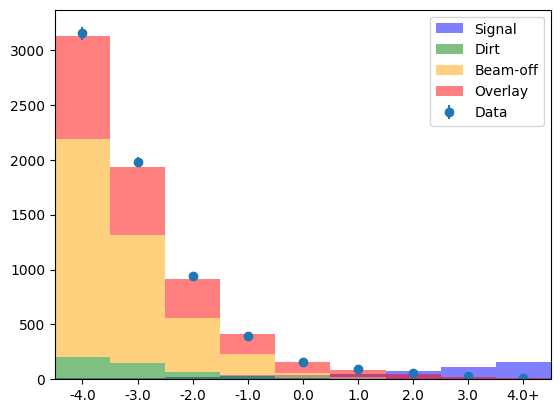

In [245]:
x_min = -7.5
x_max = 5.5
n_bins =np.arange(x_min, x_max, 1) 

start_ind = 3
end_ind = start_ind + len(n_bins)

logit_sig = np.clip(df_sig_dict[name]['logit_pred'], x_min, x_max)
w_sig = np.clip(df_sig_dict[name]['scale_factor_ls']*new_hist_scaling[name], x_min, x_max)
hist_sig, bins = np.histogram(logit_sig, bins=n_bins, weights=w_sig)
bin_centres = (bins[:-1] + bins[1:])/2

logit_ovl = np.clip(df_overlay_dict[name]['logit_pred'], x_min, x_max)
w_ovl = np.clip(df_overlay_dict[name]['scale_factor_ls']*df_overlay_dict[name]['ppfx_cv_ls'], x_min, x_max)
hist_ovl, bins = np.histogram(logit_ovl, bins=n_bins, weights=w_ovl)

logit_dirt = np.clip(df_dirt_dict[name]['logit_pred'], x_min, x_max)
w_dirt = np.clip(df_dirt_dict[name]['scale_factor_ls']*df_dirt_dict[name]['ppfx_cv_ls'], x_min, x_max)
hist_dirt, bins = np.histogram(logit_dirt, bins=n_bins, weights=w_dirt)

logit_ext = np.clip(df_beamoff_dict[name]['logit_pred'], x_min, x_max)
w_ext = np.clip(df_beamoff_dict[name]['scale_factor_ls'], x_min, x_max)
hist_ext, bins = np.histogram(logit_ext, bins=n_bins, weights=w_ext)

logit_data = np.clip(df_data_dict[name]['logit_pred'], x_min, x_max)
hist_data, bins = np.histogram(logit_data, bins=n_bins)


plt.bar(bin_centres, hist_sig, width=1, color='blue', alpha=0.5, label='Signal')

plt.bar(bin_centres, hist_dirt, width=1, color='green', alpha=0.5, label='Dirt')
h = hist_dirt
plt.bar(bin_centres, hist_ext, width=1, color='orange', bottom=h, alpha=0.5, label='Beam-off')
h+=hist_ext
plt.bar(bin_centres, hist_ovl, width=1, color='red', bottom=h, alpha=0.5, label='Overlay')
h+=hist_ovl
# plt.hist([logit_sig, logit_ovl, logit_dirt, logit_ext], bins=bins, histtype='step', weights=[w_sig, w_ovl,w_dirt,w_ext], label=['Signal', 'Overlay', 'Dirt', 'Beam-off'], stacked=True)




chi_square = np.sum((hist_data[start_ind:end_ind] - h[start_ind:end_ind])**2/np.sqrt(h[start_ind:end_ind]**2 + (0.2*h[start_ind:end_ind])**2 + hist_data[start_ind:end_ind]**2))

print(f"Chi square per degree of freedom: {chi_square}/{(len(n_bins[start_ind:end_ind])-1)}")
plt.errorbar(bin_centres, hist_data, yerr=np.sqrt(hist_data), fmt='o', label='Data')

# Create custom labels
labels = [str(round(center, 2)) for center in bin_centres]
labels[-1] = f'{round(bin_centres[-1], 2)}+'  # Label the final bin as 'n+'

# Set custom x-tick labels
plt.xticks(bin_centres, labels)
plt.xlim(n_bins[start_ind:end_ind][0], n_bins[start_ind:end_ind][-1])
plt.legend()
plt.show()

# plt.yscale('log')

### Functions and classes for data prep

In [246]:
def df_processing(df, label, scaler=None):
   input_variables = ['shr_energy_tot_ls', 'pfnplanehits_Y_ls',
       'contained_fraction_ls', 'shr_pitch_u_v_ls', 'trk_energy_ls','shr_start_x_ls',
       'theta_ls', 'reco_nu_vtx_sce_x_ls', 'reco_nu_vtx_sce_y_ls',
       'reco_nu_vtx_sce_z_ls', 'npi0_ls', 'crtveto_ls', 'slpdg_ls',
       'trk_score_v_ls', 'topological_score_ls','NeutrinoEnergy2_ls',
       'shr_px_ls', 'shr_px_v_ls', 'shr_pz_ls', 'trk_len_v_ls', 'shr_theta_ls',
       'trk_len_v_ls', 'pfnhits_ls', 'nslice_ls',
       'shr_py_v_ls', 'shr_pz_v_ls', 'shr_start_x_v_ls', 'shr_start_y_v_ls',
       'shr_start_z_v_ls', 'shr_dedx_y_v_ls', 'Counts_ls', 'dist_bw_koto_shower_x_ls',
       'dist_bw_koto_shower_y_ls', 'dist_bw_koto_shower_z_ls',
       'dist_bw_koto_shower_ls', 'shr_energy_y_v_corrected_ls'
       ]


   df_input = df[input_variables].copy("deep")

   if scaler is not None:
      col_names = df_input.columns
      arr_input = scaler.transform(df_input)
      df_input = pd.DataFrame(arr_input, columns=col_names)
   df_input['label'] = label
   return df_input

class dataset(torch.utils.data.Dataset):

    def __init__(self, X, Y):
        self.features = X
        self.labels = torch.reshape(Y, (-1, 1))

    def __len__(self):
        """return number of points in our dataset"""

        return len(self.features)

    def __getitem__(self, idx):
        """ Here we have to return the item requested by `idx`
            The PyTorch DataLoader class will use this method to make an iterable for
            our training or validation loop.
        """

        feature = self.features[idx]
        label = self.labels[idx]

        return feature, label
    
def logit(x):
    return np.log(x/(1-x))

def plot_logit_comparison(df_sig, df_bkg, nn_pred_sig=None, nn_pred_bkg=None, name='100_1shr_KDIF'):
    # Configuring the plot dimensions and limits
    # Defines the clipping/overflow bins, and max height of the one (two) plot(s)
    x_min = -8
    x_max = 8
    ymax = 400
    n_bins =np.arange(x_min, x_max, 1) 
    # Defines which bins are shown -  no additional overflow
    start_ind = 0
    end_ind = start_ind + len(n_bins)

    logit_sig = np.clip(df_sig['logit_pred'], x_min, x_max)
    w_sig = np.clip(df_sig['scale_factor_ls']*new_hist_scaling[name], x_min, x_max)
    hist_sig, bins = np.histogram(logit_sig, bins=n_bins, weights=w_sig)
    bin_centres = (bins[:-1] + bins[1:])/2

    logit_bkg = np.clip(df_bkg['logit_pred'], x_min, x_max)
    w_bkg = np.clip(df_bkg['scale_factor_ls']*df_bkg['ppfx_cv_ls'], x_min, x_max)
    hist_bkg, bins = np.histogram(logit_bkg, bins=n_bins, weights=w_bkg)

    plt.bar(bin_centres, hist_sig, width=1, color="none", edgecolor='blue', alpha=0.5, label='Signal')
    plt.bar(bin_centres, hist_bkg, width=1, color='green', alpha=0.5, label='Bkg')    
    # Create custom labels
    labels = [str(round(center, 2)) for center in bin_centres]
    labels[-1] = f'{round(bin_centres[-1], 2)}+'  # Label the final bin as 'n+'
    ymax = 400
    # Set custom x-tick labels
    plt.title(f'BDT Score {name}')
    plt.xticks(bin_centres, labels)
    plt.xlim(n_bins[start_ind:end_ind][0], n_bins[start_ind:end_ind][-1])
    plt.ylim(0, ymax*1.1)
    plt.legend()
    plt.show()    

    if nn_pred_sig is not None and nn_pred_bkg is not None:
        logit_nn_sig = np.clip(logit(nn_pred_sig), x_min, x_max)
        logit_nn_sig = np.reshape(logit_nn_sig, (-1,))
        w_nn_sig = (np.clip(df_sig['scale_factor_ls']*new_hist_scaling[name], x_min, x_max))
        
        
        print(np.shape(logit_nn_sig), np.shape(w_nn_sig))
        hist_nn_sig, bins = np.histogram(logit_nn_sig, bins=n_bins, weights=(w_nn_sig))

        logit_nn_bkg = np.clip(logit(nn_pred_bkg), x_min, x_max)
        logit_nn_bkg = np.reshape(logit_nn_bkg, (-1,))
        w_nn_bkg = np.clip(df_bkg['scale_factor_ls']*df_bkg['ppfx_cv_ls'], x_min, x_max)
        
        print(np.shape(logit_nn_bkg), np.shape(w_nn_bkg))
        hist_nn_bkg, bins = np.histogram(logit_nn_bkg, bins=n_bins, weights=w_nn_bkg)

        plt.bar(bin_centres, hist_nn_sig, width=1, color="none", edgecolor='red', alpha=0.5, label='NN Signal')
        plt.bar(bin_centres, hist_nn_bkg, width=1, color='orange', alpha=0.5, label='NN Bkg')    
        # Create custom labels
        labels = [str(round(center, 2)) for center in bin_centres]
        labels[-1] = f'{round(bin_centres[-1], 2)}+'

        
        plt.xticks(bin_centres, labels)
        plt.xlim(n_bins[start_ind:end_ind][0], n_bins[start_ind:end_ind][-1])
        plt.ylim(0, ymax*1.1)
        plt.legend()
        plt.title(f'DNN Score {name}')
        plt.show()

        return bin_centres, [hist_sig, hist_nn_sig], [hist_bkg, hist_nn_bkg]

    return bin_centres, [hist_sig], [hist_bkg] 

def prepare_data(df, label, scaler=None, use_scaler=False, use_device='cpu', ):   
    if use_scaler and scaler is not None:
        df_input = df_processing(df, label, scaler=scaler)
    elif use_scaler and scaler is None:
        no_scaling = df_processing(df, label)
        no_scaling.drop('label', axis=1, inplace=True)
        scaler = preprocessing.StandardScaler().fit(no_scaling)
        df_input = df_processing(df, label, scaler=scaler)
    else:
        no_scaling = df_processing(df, label)
        no_scaling.drop('label', axis=1, inplace=True)
        scaler = preprocessing.StandardScaler().fit(no_scaling)
        df_input = df_processing(df, label)
    
    Y = torch.tensor(df_input['label'].to_numpy(dtype=np.float32), device=use_device)
    X = torch.tensor(df_input.drop('label', axis=1).to_numpy(dtype=np.float32), device=use_device)

    return X, Y, scaler


def merge_split_datasets(X_arr, Y_arr, split_frac_arr=[0.6, 0.2, 0.2]):
    if len(X_arr) != len(Y_arr):
        print("X and Y arrays are not the same length")
        print("Returning unsplit tensors")
        return [X], [Y]
    
    X = X_arr[0]
    Y = Y_arr[0]

    for i in range(1, len(X_arr)):
        X = torch.cat((X, X_arr[i]), 0)
        Y = torch.cat((Y, Y_arr[i]), 0)
   

    if len(split_frac_arr) == 1 and split_frac_arr[0] == 1:
        return [X], [Y]
    if sum(split_frac_arr) != 1:
        print("Split fractions do not sum to 1")
        print("Returning unsplit tensors")
        return [X], [Y]
    X_arr = []
    Y_arr = []
    for i in range(len(split_frac_arr)-1):
        if split_frac_arr[i] < 0 or split_frac_arr[i] > 1:
            print("Invalid split fraction")
            print("Returning unsplit tensors")
            return [X], [Y]
        
        frac = split_frac_arr[i] / sum(split_frac_arr[i:])
        X_1, X_2, Y_1, Y_2 = train_test_split(X, Y, test_size=frac)
        X_arr.append(X_1)
        Y_arr.append(Y_1)
        X = X_2
        Y = Y_2
    X_1, X_2, Y_1, Y_2 = train_test_split(X, Y, test_size=0.5)
    X_1 = torch.concat((X_1, X_2), 0)
    Y_1 = torch.concat((Y_1, Y_2), 0)
    
    X_arr.append(X_1)
    Y_arr.append(Y_1)
    return X_arr, Y_arr
    



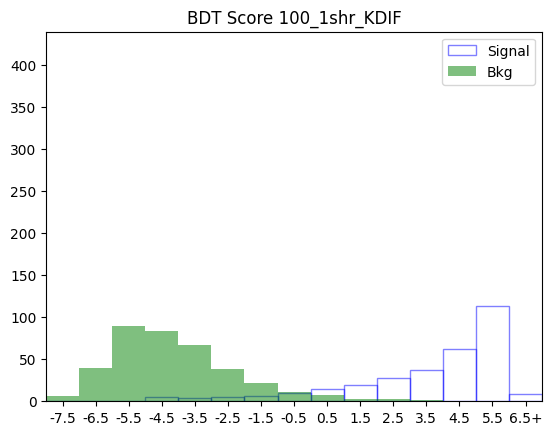

In [248]:
frac = 0.75

df_sig = df_sig_dict[name]
df_sig_train = df_sig[:int(len(df_sig)*frac)]
df_sig_test = df_sig[int(len(df_sig)*frac):]

df_bkg = df_overlay_dict[name]
df_bkg_train = df_bkg[:int(len(df_bkg)*frac)]
df_bkg_test = df_bkg[int(len(df_bkg)*frac):][::3]

plot_logit_comparison(df_sig_test, df_bkg_test)

X_sig, Y_sig, scaler = prepare_data(df_sig_train, 1, scaler=None, use_scaler=True)
X_bkg, Y_bkg, scaler = prepare_data(df_bkg_train, 0 , scaler=scaler, use_scaler=True)
X_arr, Y_arr = merge_split_datasets([X_sig, X_bkg], [Y_sig, Y_bkg], split_frac_arr=[0.85, 0.15])

dataset_arr = []
loader_arr = []
for i, X in enumerate(X_arr):
    sample = dataset(X, Y_arr[i])
    dataset_arr.append(sample)
    loader = torch.utils.data.DataLoader(sample, batch_size=16, shuffle=True)
    loader_arr.append(loader)
train, val = dataset_arr
trainloader, valloader = loader_arr

## Defining a DNN

In [249]:
class NeuralNet(nn.Module):
    def __init__(self, n_inputs, device='cpu'):
        super(NeuralNet, self).__init__()
        self.batchnorm = nn.BatchNorm1d(n_inputs)
        self.fc1 = nn.Linear(n_inputs, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 1)
        self.to(device)
        self.loss_history = []
        self.accuracy_history = []

    def forward(self, x, training=False, p = 0.1):
        p1 = self.batchnorm(x)
        c1 = F.relu(F.dropout(self.fc1(p1), p=p, training=training))
        c2 = F.relu(F.dropout(self.fc2(c1), p=p, training=training))
        out = F.sigmoid(F.dropout(self.fc3(c2), p=p, training=training))
        return out
    
    def predict(self, x):
        return self.forward(x)
    
    def train(self, dataloader, optimizer, criterion, validation = None, epochs=10, log_length=50, verbose = True, weights=False, device='cpu'):
        if validation is not None:
            self.val_loss_history = []
            self.val_acc_history = []

        for epoch in range(epochs):
            if verbose:
                print('--------------------------------')
                print(f'Epoch {epoch+1}')
                print('--------------------------------')
            running_loss = 0.0
            running_accuracy = 0.0
            i=0
            for data in dataloader:
                inputs, labels = data
                # Check for NaN or infinite values in inputs and labels
                if torch.isnan(inputs).any() or torch.isinf(inputs).any():
                    print("NaN or infinite values found in inputs")
                    continue
                if torch.isnan(labels).any() or torch.isinf(labels).any():
                    print("NaN or infinite values found in labels")
                    continue
                 # Zero the parameter gradients
                optimizer.zero_grad()
                # Forward + backward + optimize
                outputs = self.forward(inputs, training=True)
                if weights:
                    w = np.where(np.array(labels)==0, 1/2, 1)
                
                    loss_weighted = torch.nn.BCELoss(weight=torch.tensor(w, device=device))
                    
                    loss = loss_weighted(outputs, labels)
                else:
                    loss = criterion(outputs, labels)
                accuracy = (outputs.round() == labels).float()
                # Check for NaN or infinite values in loss
                if torch.isnan(loss).any() or torch.isinf(loss).any():
                    print("NaN or infinite values found in loss")
                    continue
                loss.backward()
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
                optimizer.step()
                # Print statistics
                running_loss += loss.item()
                running_accuracy += accuracy.mean().item()
                if i % log_length == log_length-1:  # Print every N mini-batches
                    if verbose:
                        print(f'Batch {i+1}')
                        print(f'Training loss: {running_loss / log_length:.3f}')
                        print(f'Training accuracy: {running_accuracy / log_length:.3f}')
                        
                    self.loss_history.append(running_loss/log_length)
                    self.accuracy_history.append(running_accuracy/log_length)
                    running_loss = 0.0
                    running_accuracy = 0.0
                    
                    if validation is not None:
                        pred_val = self(validation.features)
                        val_loss = criterion(outputs, labels).item()
                        val_accuracy = (outputs.round() == labels).float()
                        if verbose:
                            print(f'Validation loss: {val_loss:.3f}')
                            print(f'Validation accuracy: {val_accuracy.mean().item():.3f}')
                            
                        self.val_loss_history.append(val_loss)
                        self.val_acc_history.append(val_accuracy.mean().item())
                    if verbose:
                        print('--------------------------------')
                i+=1
        


### DNN Training

In [250]:
use_device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = NeuralNet(len(X_sig[0]), device=use_device)
net.train(trainloader, torch.optim.RAdam(net.parameters(), lr=0.001), torch.nn.BCELoss(), epochs=50, log_length=50, validation=val, verbose=True, weights=True)

--------------------------------
Epoch 1
--------------------------------
Batch 50
Training loss: 0.354
Training accuracy: 0.821
Validation loss: 0.519
Validation accuracy: 0.938
--------------------------------
Batch 100
Training loss: 0.267
Training accuracy: 0.886
Validation loss: 0.323
Validation accuracy: 0.812
--------------------------------


/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_92430/584503191.py:49: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  w = np.where(np.array(labels)==0, 1/2, 1)


Batch 150
Training loss: 0.207
Training accuracy: 0.902
Validation loss: 0.284
Validation accuracy: 0.938
--------------------------------
--------------------------------
Epoch 2
--------------------------------
Batch 50
Training loss: 0.173
Training accuracy: 0.931
Validation loss: 0.261
Validation accuracy: 0.938
--------------------------------
Batch 100
Training loss: 0.179
Training accuracy: 0.909
Validation loss: 0.460
Validation accuracy: 0.812
--------------------------------
Batch 150
Training loss: 0.160
Training accuracy: 0.915
Validation loss: 0.274
Validation accuracy: 0.938
--------------------------------
--------------------------------
Epoch 3
--------------------------------
Batch 50
Training loss: 0.157
Training accuracy: 0.915
Validation loss: 0.308
Validation accuracy: 0.875
--------------------------------
Batch 100
Training loss: 0.171
Training accuracy: 0.921
Validation loss: 0.311
Validation accuracy: 0.875
--------------------------------
Batch 150
Training l

### Training metrics

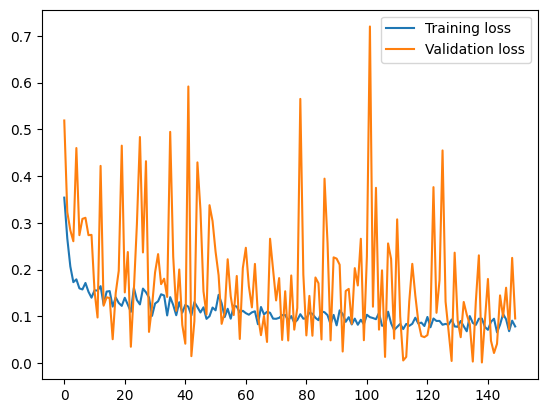

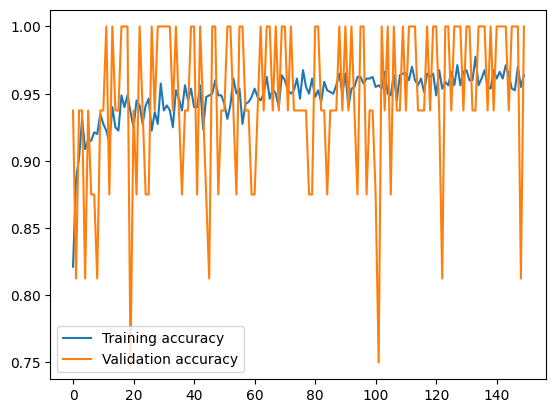

In [251]:
plt.plot(net.loss_history, label='Training loss')
plt.plot(net.val_loss_history, label='Validation loss')
plt.legend()
plt.show()

plt.plot(net.accuracy_history, label='Training accuracy')
plt.plot(net.val_acc_history, label='Validation accuracy')
plt.legend()    
plt.show()

In [252]:
X_sig_test, Y_sig_test, scaler = prepare_data(df_sig_test, 1, scaler=scaler, use_scaler=False)
X_bkg_test, Y_bkg_test, scaler = prepare_data(df_bkg_test, 0 , scaler=scaler, use_scaler=False)
X_test, Y_test = merge_split_datasets([X_sig_test, X_bkg_test], [Y_sig_test, Y_bkg_test], split_frac_arr=[1.0])
test_dataset = dataset(X_test[0], Y_test[0])
feature, label = test_dataset.features, test_dataset.labels
pred_test = net.predict(feature).detach().numpy()

accuracy = (pred_test.round() == label).float().mean().item()
print(f'Accuracy on test set: {accuracy*100:.2f}%')

Accuracy on test set: 94.55%


### Confusion matrices

In [254]:
def plot_confusion(y, pred):
    roc = metrics.roc_auc_score(y, pred)
    print(f'ROC AUC score: {roc:.3f}')

    confusion_matrix = metrics.confusion_matrix(y, pred.round())
    print(confusion_matrix)
    plt.imshow(confusion_matrix, interpolation='nearest')
    plt.colorbar()
    # Define class names
    class_names = ['Background', 'Signal']

    # Set axis labels
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Set tick labels
    plt.xticks(np.arange(len(class_names)), class_names)
    plt.yticks(np.arange(len(class_names)), class_names)


    # Add text annotations
    thresh = confusion_matrix.max() / 2.
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, format(confusion_matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="black" if confusion_matrix[i, j] > thresh else "white")
    plt.gca().invert_yaxis()
    plt.show()

In [255]:
df_sig_test['label'] = 1
df_bkg_test['label'] = 0
bdt_pred = pd.concat([df_sig_test[['pred', 'label']], df_bkg_test[['pred', 'label']]])



/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_92430/3758083475.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sig_test['label'] = 1


NN
ROC AUC score: 0.982
[[1868   22]
 [ 129  753]]


/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_92430/3882225370.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sig_test['label'] = 1


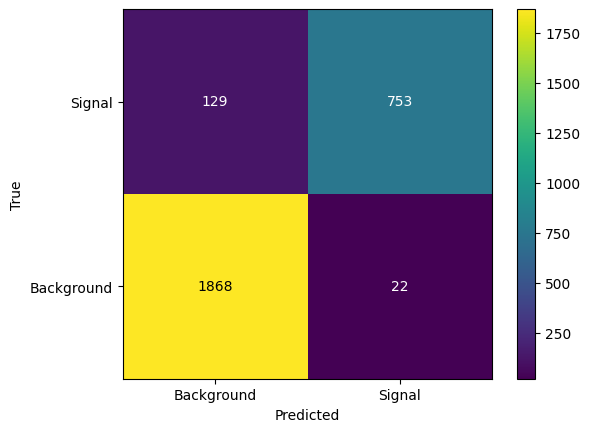

BDT
ROC AUC score: 0.978
[[1811   79]
 [  86  796]]


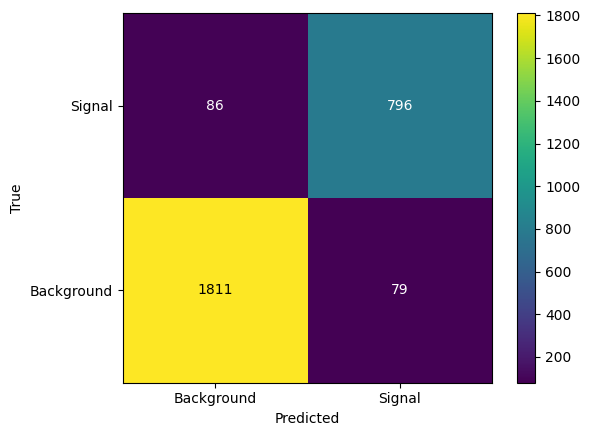

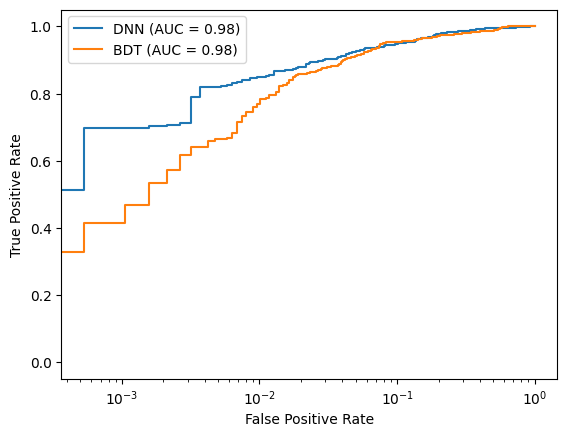

In [256]:
df_sig_test['label'] = 1
df_bkg_test['label'] = 0
bdt_pred = pd.concat([df_sig_test[['pred', 'label']], df_bkg_test[['pred', 'label']]])

print("NN")
plot_confusion(label, pred_test)
print("BDT")
plot_confusion(bdt_pred['label'], bdt_pred['pred'])

fpr, tpr, thresholds = metrics.roc_curve(label, pred_test)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'DNN (AUC = {roc_auc:.2f})')

fpr, tpr, thresholds = metrics.roc_curve(bdt_pred['label'], bdt_pred['pred'])
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'BDT (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.xscale('log')
plt.show()

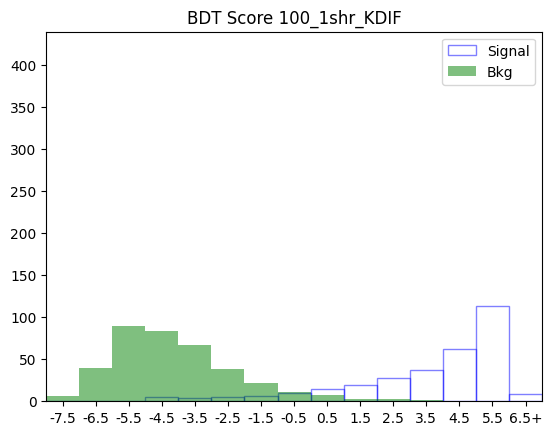

(882,) (882,)
(1890,) (1890,)


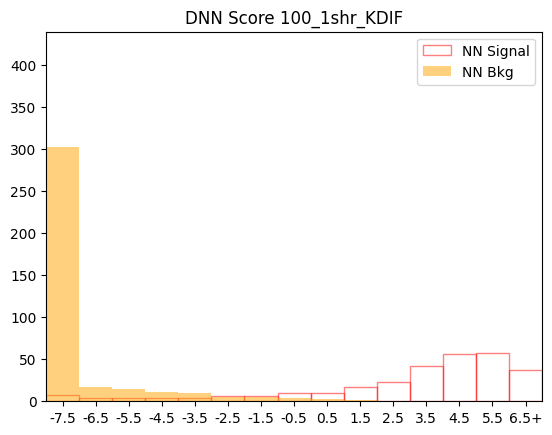

In [257]:
X_test, Y_test = merge_split_datasets([X_sig_test, X_bkg_test], [Y_sig_test, Y_bkg_test], split_frac_arr=[1.0])
X_sig_test_merge, Y_sig_test_merge = merge_split_datasets([X_sig_test], [Y_sig_test], split_frac_arr=[1.0])
X_bkg_test_merge, Y_bkg_test_merge = merge_split_datasets([X_bkg_test], [Y_bkg_test], split_frac_arr=[1.0])

test_dataset = dataset(X_test[0], Y_test[0])
# sig_dataset = dataset(X_sig_test_merge[0], Y_sig_test_merge[0])
# bkg_dataset = dataset(X_bkg_test_merge[0], Y_bkg_test_merge[0])

# feature, labels_sig = sig_dataset.features, sig_dataset.labels
# pred_sig = net.predict(feature).detach().numpy()
# feature, labels_bkg = bkg_dataset.features, bkg_dataset.labels
# pred_bkg = net.predict(feature).detach().numpy()
feature, labels_test = test_dataset.features, test_dataset.labels
pred_test = net.predict(feature).detach().numpy()

# y = np.concatenate((labels_sig, labels_bkg))
# pred = np.concatenate((pred_sig, pred_bkg))
# plot_confusion(y, pred)

pred_sig = np.where(labels_test==1, pred_test, -1)
mask = pred_sig != -1
pred_sig = pred_sig[mask]
pred_bkg = np.where(labels_test==0, pred_test, -1)
mask = pred_bkg != -1
pred_bkg = pred_bkg[mask]
bin_centres, [hist_sig, hist_nn_sig], [hist_bkg, hist_nn_bkg] = plot_logit_comparison(df_sig_test, df_bkg_test, nn_pred_sig=pred_sig, nn_pred_bkg=pred_bkg)



In [258]:
def get_purity_efficiency(count_sig, count_bkg, tot_sig, tot_bkg):
    purity = count_sig / (count_sig + count_bkg)
    efficiency_sig = count_sig / tot_sig.sum()
    efficiency_bkg = count_bkg / tot_bkg.sum()
    return purity, efficiency_sig, efficiency_bkg

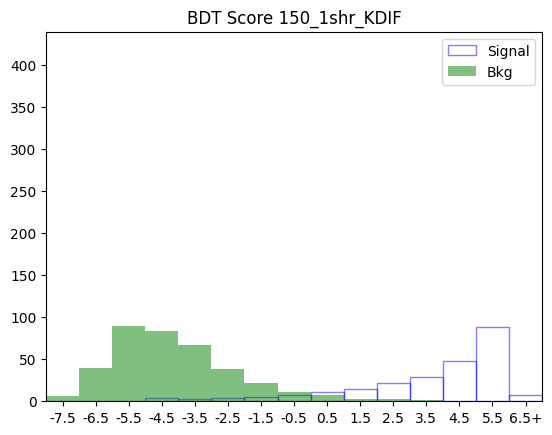

(882,) (882,)
(1890,) (1890,)


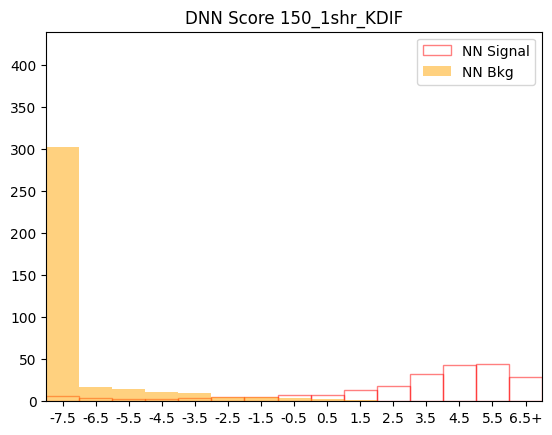

Making a cut at logit > -1.0
BDT
Sig = 227.85283854909667, Bkg = 26.64609226721319
SIG:BKG = 8.55
Purity = 0.8952997869902818
Efficiency Signal = 0.935374149659865
Efficiency Background = 0.07125670827477437
NN:
Sig = 194.71060748741004, Bkg = 7.696286204401247
SIG:BKG = 25.30
Purity = 0.9619761656136092
Efficiency Signal = 0.8746898263027318
Efficiency Background = 0.020581330101486824


In [259]:
X_test, Y_test = merge_split_datasets([X_sig_test, X_bkg_test], [Y_sig_test, Y_bkg_test], split_frac_arr=[1.0])
X_sig_test_merge, Y_sig_test_merge = merge_split_datasets([X_sig_test], [Y_sig_test], split_frac_arr=[1.0])
X_bkg_test_merge, Y_bkg_test_merge = merge_split_datasets([X_bkg_test], [Y_bkg_test], split_frac_arr=[1.0])

test_dataset = dataset(X_test[0], Y_test[0])
# sig_dataset = dataset(X_sig_test_merge[0], Y_sig_test_merge[0])
# bkg_dataset = dataset(X_bkg_test_merge[0], Y_bkg_test_merge[0])

# feature, labels_sig = sig_dataset.features, sig_dataset.labels
# pred_sig = net.predict(feature).detach().numpy()
# feature, labels_bkg = bkg_dataset.features, bkg_dataset.labels
# pred_bkg = net.predict(feature).detach().numpy()
feature, labels_test = test_dataset.features, test_dataset.labels
pred_test = net.predict(feature).detach().numpy()

# y = np.concatenate((labels_sig, labels_bkg))
# pred = np.concatenate((pred_sig, pred_bkg))
# plot_confusion(y, pred)

pred_sig = np.where(labels_test==1, pred_test, -1)
mask = pred_sig != -1
pred_sig = pred_sig[mask]
pred_bkg = np.where(labels_test==0, pred_test, -1)
mask = pred_bkg != -1
pred_bkg = pred_bkg[mask]
bin_centres, [hist_sig, hist_nn_sig], [hist_bkg, hist_nn_bkg] = plot_logit_comparison(df_sig_test, df_bkg_test, nn_pred_sig=pred_sig, nn_pred_bkg=pred_bkg, name=name)

logit_cut = -1

logit_index = np.where(bin_centres > logit_cut)[0][0]



print("Making a cut at logit > {:.1f}".format(logit_cut))

# cut_sig = np.where(df_sig_test['logit_pred'] > logit_cut, 1, 0)
# cut_bkg = np.where(df_bkg_test['logit_pred'] > logit_cut, 1, 0)

cut_sig = hist_sig[logit_index:]
cut_bkg = hist_bkg[logit_index:]
purity, eff_sig, eff_bkg = get_purity_efficiency(sum(cut_sig), sum(cut_bkg), sum(hist_sig), sum(hist_nn_bkg))


print("BDT")
print(f"Sig = {sum(cut_sig)}, Bkg = {sum(cut_bkg)}")
print(f"SIG:BKG = {sum(cut_sig)/sum(cut_bkg):.2f}")

print(f"Purity = {purity}")
print(f"Efficiency Signal = {eff_sig}")
print(f"Efficiency Background = {eff_bkg}")

# cut_sig = np.where(logit(pred_sig) > logit_cut, 1, 0)
# cut_bkg = np.where(logit(pred_bkg) > logit_cut, 1, 0)

cut_nn_sig = hist_nn_sig[logit_index:]
cut_nn_bkg = hist_nn_bkg[logit_index:]
purity, eff_sig, eff_bkg = get_purity_efficiency(sum(cut_nn_sig), sum(cut_nn_bkg), sum(hist_nn_sig), sum(hist_nn_bkg))


print("NN:")
print(f"Sig = {sum(cut_nn_sig)}, Bkg = {sum(cut_nn_bkg)}")
print(f"SIG:BKG = {sum(cut_nn_sig)/sum(cut_nn_bkg):.2f}")


print(f"Purity = {purity}")
print(f"Efficiency Signal = {eff_sig}")
print(f"Efficiency Background = {eff_bkg}")

## How does this NN perform on other (slightly different) datasets?

This is a poor comparison, as the **background is the same for all datasets** - should never test using elements of the training dataset!
Can still compare the signal however, as they are independent of one-another!

In [266]:
def plot_confusion_roc(bdt_pred, dnn_pred):

    print("NN")
    plot_confusion(dnn_pred['label'], dnn_pred['pred'])
    print("BDT")
    plot_confusion(bdt_pred['label'], bdt_pred['pred'])

    fpr, tpr, thresholds = metrics.roc_curve(dnn_pred['label'], dnn_pred['pred'])
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'DNN (AUC = {roc_auc:.2f})')

    fpr, tpr, thresholds = metrics.roc_curve(bdt_pred['label'], bdt_pred['pred'])
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'BDT (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.xscale('log')
    plt.show()

In [267]:
def plot_bdt_vs_cnn(df_sig, df_bkg, labels, bdt_pred, dnn_pred, logit_cut=0, name='100_1shr_KDIF'):
    plot_confusion_roc(bdt_pred, dnn_pred)

    pred_sig = np.where(labels==1, dnn_pred, -1)
    mask = pred_sig != -1
    pred_sig = pred_sig[mask]
    pred_bkg = np.where(labels==0, dnn_pred, -1)
    mask = pred_bkg != -1
    pred_bkg = pred_bkg[mask]
    bin_centres, [hist_sig, hist_nn_sig], [hist_bkg, hist_nn_bkg] = plot_logit_comparison(df_sig, df_bkg, nn_pred_sig=pred_sig, nn_pred_bkg=pred_bkg, name=name)

    logit_cut = -1
    logit_index = np.where(bin_centres > logit_cut)[0][0]

    print("Making a cut at logit > {:.1f}".format(logit_cut))

    # cut_sig = np.where(df_sig_test['logit_pred'] > logit_cut, 1, 0)
    # cut_bkg = np.where(df_bkg_test['logit_pred'] > logit_cut, 1, 0)

    cut_sig = hist_sig[logit_index:]
    cut_bkg = hist_bkg[logit_index:]
    purity, eff_sig, eff_bkg = get_purity_efficiency(sum(cut_sig), sum(cut_bkg), sum(hist_sig), sum(hist_bkg))

    print("BDT")
    # print(f"Sig = {sum(cut_sig)}, Bkg = {sum(cut_bkg)}")
    # print(f"SIG:BKG = {sum(cut_sig)/sum(cut_bkg):.2f}")
    print(f"Purity = {purity}")
    print(f"Efficiency Signal = {eff_sig}")
    print(f"Efficiency Background = {eff_bkg}")

    # cut_sig = np.where(logit(pred_sig) > logit_cut, 1, 0)
    # cut_bkg = np.where(logit(pred_bkg) > logit_cut, 1, 0)

    cut_nn_sig = hist_nn_sig[logit_index:]
    cut_nn_bkg = hist_nn_bkg[logit_index:]
    purity, eff_sig, eff_bkg = get_purity_efficiency(sum(cut_nn_sig), sum(cut_nn_bkg), sum(hist_nn_sig), sum(hist_nn_bkg))


    print("NN:")
    # print(f"Sig = {sum(cut_nn_sig)}, Bkg = {sum(cut_nn_bkg)}")
    # print(f"SIG:BKG = {sum(cut_nn_sig)/sum(cut_nn_bkg):.2f}")
    print(f"Purity = {purity}")
    print(f"Efficiency Signal = {eff_sig}")
    print(f"Efficiency Background = {eff_bkg}")


In [274]:
# Selecting the 200 MeV sample
Run = "3"
HPS_mass = 150
shr = "1shr"
K = "KDIF"

get_TOF = False # Set to true to load time of flight values, used for the axion reweighting.
use_new_flux = False # Set to true to use the new (fixed) flux files. Currently only generated for Run3.
update_KDAR_scaling = True

name = f'{HPS_mass}_{shr}_{K}'

sig_arr, overlay_arr, dirt_arr, beamoff_arr, data_arr, detsys_arr, ov_detsys_arr = New_loader('Run'+Run, str(HPS_mass), shr, K, bool_full_sample=False, get_tof=get_TOF, for_david=False, testing_new_flux=use_new_flux, update_KDAR_scaling=update_KDAR_scaling)

Updating KDAR scaling for signal


/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_92430/1718207215.py:144: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.3125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_sig.loc[df_sig['KDAR_scale'] == 8.6, 'KDAR_scale'] = 0.085/0.016


SUCCESSFULLY LOADED THE PICKLE FILES ('Run3', '150', '1shr', 'KDIF')


In [275]:
bkg_arr = overlay_arr[::3]

X_sig, Y_sig, scaler = prepare_data(sig_arr, 1, scaler=scaler, use_scaler=True)
X_bkg, Y_bkg, scaler = prepare_data(bkg_arr, 0 , scaler=scaler, use_scaler=True)
X_arr, Y_arr = merge_split_datasets([X_sig, X_bkg], [Y_sig, Y_bkg], split_frac_arr=[1])

new_mass_sample = dataset(X_arr[0], Y_arr[0])
new_mass_loader = torch.utils.data.DataLoader(new_mass_sample, batch_size=16, shuffle=True)

print("Number of signal events: ", len(sig_arr))
print("Number of background events: ", len(bkg_arr))

feature, label = new_mass_sample.features, new_mass_sample.labels
prediction = net.predict(feature).detach().numpy()

Number of signal events:  4692
Number of background events:  5020


/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_92430/670515868.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bkg_arr['label'] = 0


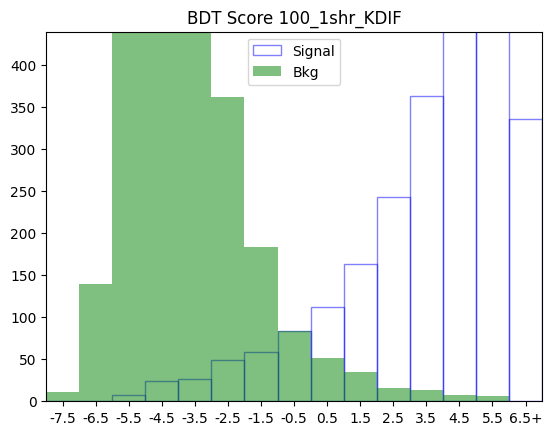

/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_92430/309311934.py:48: RuntimeWarning: divide by zero encountered in divide
  return np.log(x/(1-x))
/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_92430/309311934.py:48: RuntimeWarning: divide by zero encountered in log
  return np.log(x/(1-x))


(4692,) (4692,)
(5020,) (5020,)


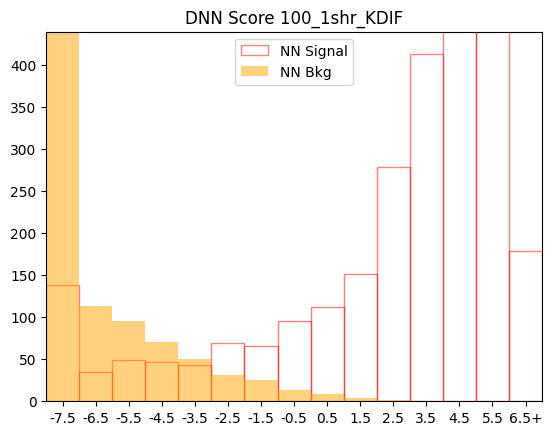

Making a cut at logit > -1.0
BDT
Purity = 0.9232556097545905
Efficiency Signal = 0.9396845694799685
Efficiency Background = 0.07354193742470772
NN:
Purity = 0.9883867288832213
Efficiency Signal = 0.834381096900073
Efficiency Background = 0.009076208901586369
NN
ROC AUC score: 0.978
[[4994   26]
 [ 927 3765]]


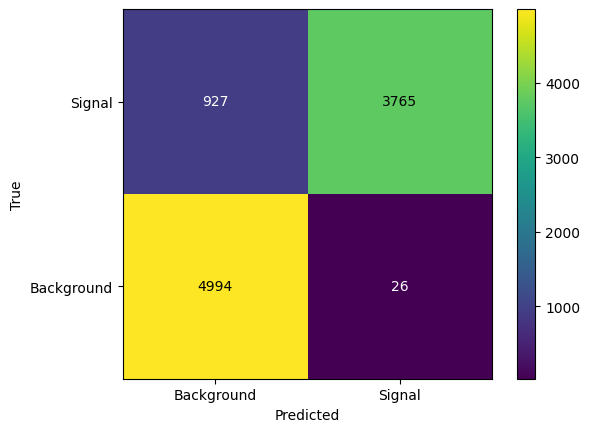

BDT
ROC AUC score: 0.976
[[4785  235]
 [ 425 4267]]


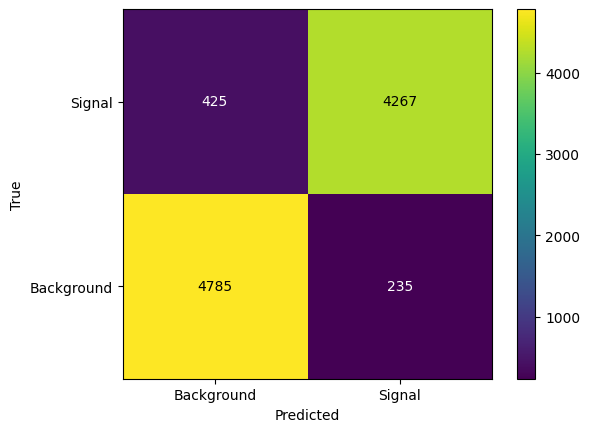

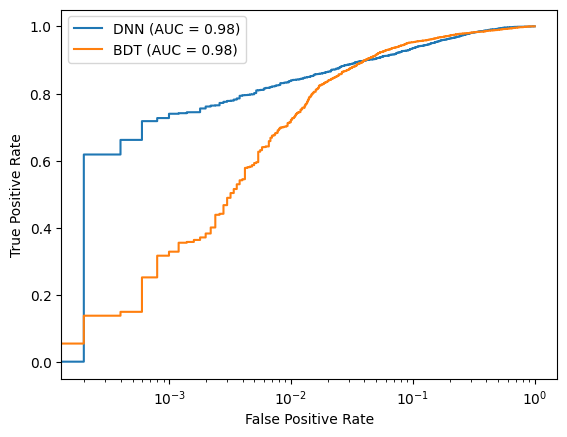

In [276]:
sig_arr['label'] = 1
bkg_arr['label'] = 0

bdt_pred = pd.concat([sig_arr[['pred', 'label']], bkg_arr[['pred', 'label']]])    
dnn_pred = pd.DataFrame({'pred':prediction.flatten(), 'label':label.detach().numpy().flatten()})

plot_bdt_vs_cnn(sig_arr, bkg_arr, dnn_pred['label'], bdt_pred, dnn_pred['pred'], logit_cut=0, name='100_1shr_KDIF')
plot_confusion_roc(bdt_pred, dnn_pred)

In [268]:
def get_predictions(df_sig, df_bkg, scaler, network, name, logit_cut=0, show_confusion_roc=False, show_logit_comparison=False):
    X_sig, Y_sig, scaler = prepare_data(df_sig, 1, scaler=scaler, use_scaler=True)
    X_bkg, Y_bkg, scaler = prepare_data(df_bkg, 0 , scaler=scaler, use_scaler=True)
    X_arr, Y_arr = merge_split_datasets([X_sig, X_bkg], [Y_sig, Y_bkg], split_frac_arr=[1])

    new_mass_sample = dataset(X_arr[0], Y_arr[0])
    new_mass_loader = torch.utils.data.DataLoader(new_mass_sample, batch_size=16, shuffle=True)

    print("Number of signal events: ", len(sig_arr))
    print("Number of background events: ", len(bkg_arr))

    feature, label = new_mass_sample.features, new_mass_sample.labels
    prediction = network.predict(feature).detach().numpy()

    df_sig['label'] = 1
    df_bkg['label'] = 0

    bdt_pred = pd.concat([df_sig[['pred', 'label']], df_bkg[['pred', 'label']]])
    print(np.shape(prediction), np.shape(label))    
    
    dnn_pred = pd.DataFrame({'pred':prediction.flatten(), 'label':label.detach().numpy().flatten()})

    if show_confusion_roc:
        plot_confusion_roc(bdt_pred, dnn_pred)

    if show_logit_comparison:
        plot_bdt_vs_cnn(df_sig, df_bkg, dnn_pred['label'], bdt_pred['pred'], dnn_pred['pred'], logit_cut=logit_cut, name=name)

Updating KDAR scaling for signal
SUCCESSFULLY LOADED THE PICKLE FILES ('Run3', '100', '1shr', 'KDAR')
Number of signal events:  1109
Number of background events:  5020
(6129, 1) torch.Size([6129, 1])


/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_92430/3903234092.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bkg['label'] = 0


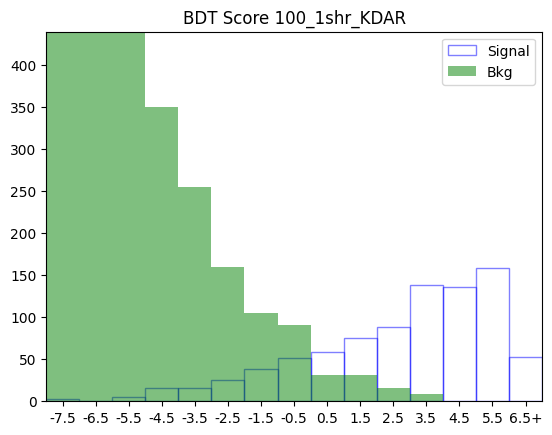

(1109,) (1109,)
(5020,) (5020,)


/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_92430/309311934.py:48: RuntimeWarning: divide by zero encountered in log
  return np.log(x/(1-x))
/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_92430/309311934.py:48: RuntimeWarning: divide by zero encountered in log
  return np.log(x/(1-x))


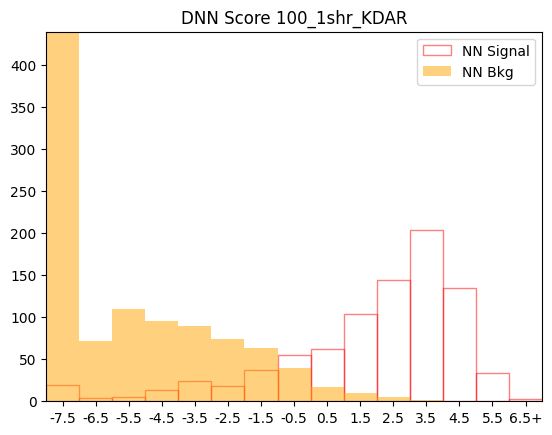

Making a cut at logit > -1.0
BDT
Purity = 0.8093439729079891
Efficiency Signal = 0.881876241839339
Efficiency Background = 0.0613024619395401
NN:
Purity = 0.9119605075510929
Efficiency Signal = 0.8583735452739111
Efficiency Background = 0.02445291817709637
Updating KDAR scaling for signal
Loading 150 MeV detsys samples
SUCCESSFULLY LOADED THE PICKLE FILES ('Run3', '125', '1shr', 'KDAR')
Number of signal events:  1091
Number of background events:  5020
(6111, 1) torch.Size([6111, 1])


/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_92430/3903234092.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bkg['label'] = 0


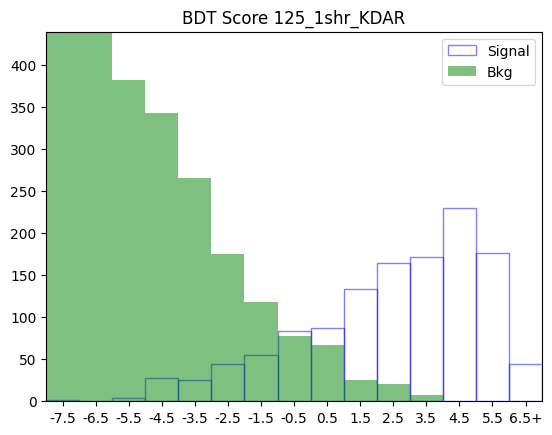

(1091,) (1091,)
(5020,) (5020,)


/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_92430/309311934.py:48: RuntimeWarning: divide by zero encountered in log
  return np.log(x/(1-x))


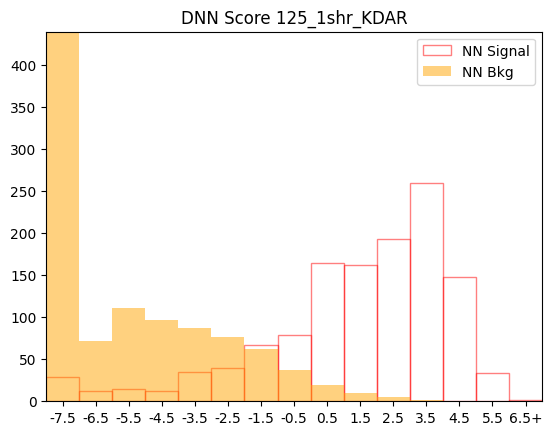

Making a cut at logit > -1.0
BDT
Purity = 0.8465694980124514
Efficiency Signal = 0.8730359167156934
Efficiency Background = 0.06775350288658553
NN:
Purity = 0.9351478857208964
Efficiency Signal = 0.8321542854682945
Efficiency Background = 0.02471145119059446
Updating KDAR scaling for signal
Loading 150 MeV detsys samples
SUCCESSFULLY LOADED THE PICKLE FILES ('Run3', '130', '1shr', 'KDAR')
Number of signal events:  1102
Number of background events:  5020
(6122, 1) torch.Size([6122, 1])


/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_92430/3903234092.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bkg['label'] = 0


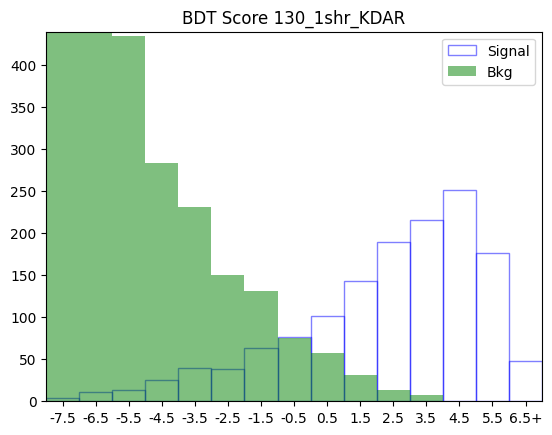

(1102,) (1102,)
(5020,) (5020,)


/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_92430/309311934.py:48: RuntimeWarning: divide by zero encountered in log
  return np.log(x/(1-x))


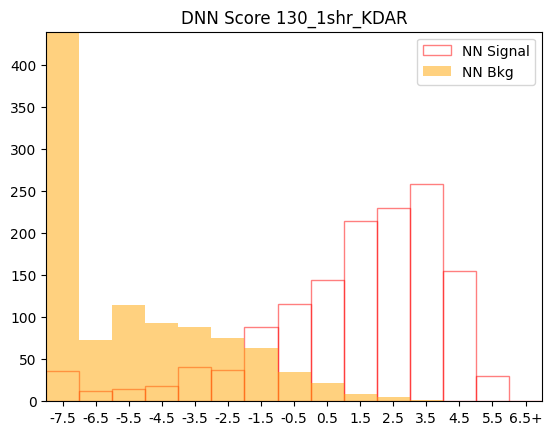

Making a cut at logit > -1.0
BDT
Purity = 0.8649350812035919
Efficiency Signal = 0.8609794852878602
Efficiency Background = 0.06422036316591194
NN:
Purity = 0.9420555400692529
Efficiency Signal = 0.8227591294725219
Efficiency Background = 0.024172915027702052
Updating KDAR scaling for signal
Loading 150 MeV detsys samples
SUCCESSFULLY LOADED THE PICKLE FILES ('Run3', '135', '1shr', 'KDAR')
Number of signal events:  1050
Number of background events:  5020
(6070, 1) torch.Size([6070, 1])


/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_92430/3903234092.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bkg['label'] = 0


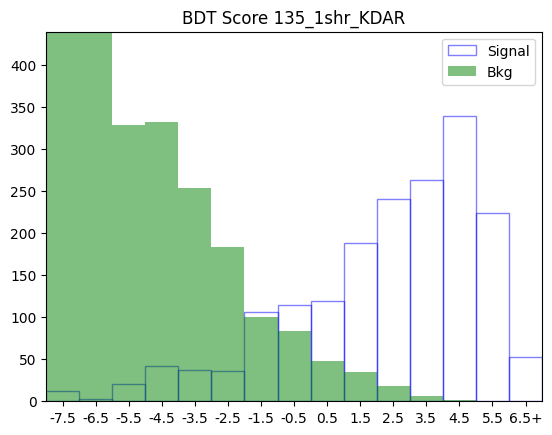

(1050,) (1050,)
(5020,) (5020,)


/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_92430/309311934.py:48: RuntimeWarning: divide by zero encountered in log
  return np.log(x/(1-x))


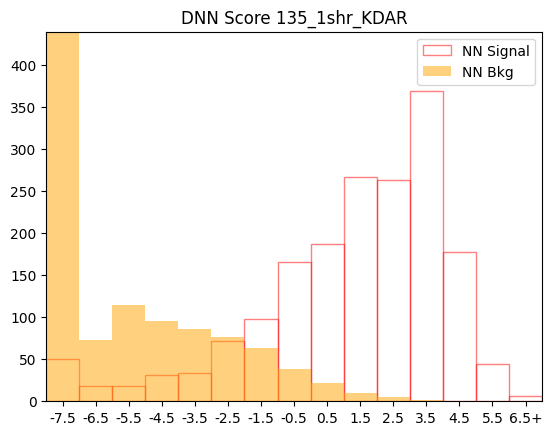

Making a cut at logit > -1.0
BDT
Purity = 0.8892597982265514
Efficiency Signal = 0.85762024107889
Efficiency Background = 0.06580360856548964
NN:
Purity = 0.9513661348708797
Efficiency Signal = 0.822263993316628
Efficiency Background = 0.025898845659878555
Updating KDAR scaling for signal
Loading 150 MeV detsys samples
SUCCESSFULLY LOADED THE PICKLE FILES ('Run3', '140', '1shr', 'KDAR')
Number of signal events:  1082
Number of background events:  5020
(6102, 1) torch.Size([6102, 1])


/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_92430/3903234092.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bkg['label'] = 0


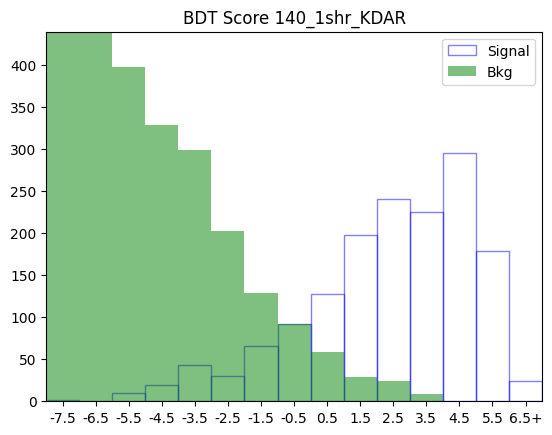

(1082,) (1082,)
(5020,) (5020,)


/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_92430/309311934.py:48: RuntimeWarning: divide by zero encountered in log
  return np.log(x/(1-x))


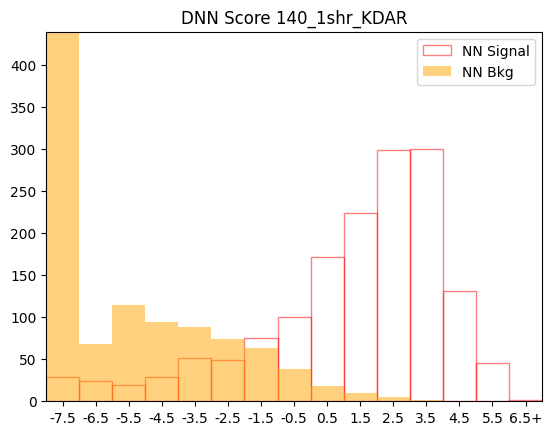

Making a cut at logit > -1.0
BDT
Purity = 0.8665871072121625
Efficiency Signal = 0.8909999020663979
Efficiency Background = 0.07284461874296679
NN:
Purity = 0.9463133273947972
Efficiency Signal = 0.8211172824824752
Efficiency Background = 0.024738363423629568
Updating KDAR scaling for signal
Loading 150 MeV detsys samples
SUCCESSFULLY LOADED THE PICKLE FILES ('Run3', '145', '1shr', 'KDAR')
Number of signal events:  1014
Number of background events:  5020
(6034, 1) torch.Size([6034, 1])


/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_92430/3903234092.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bkg['label'] = 0


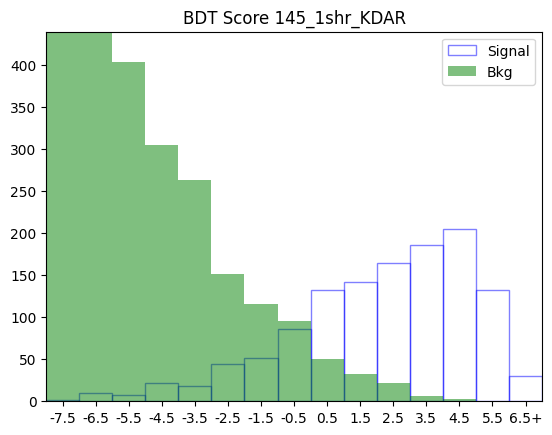

(1014,) (1014,)
(5020,) (5020,)


/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_92430/309311934.py:48: RuntimeWarning: divide by zero encountered in log
  return np.log(x/(1-x))


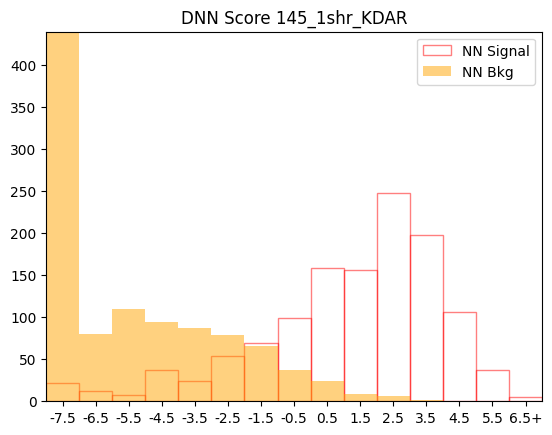

Making a cut at logit > -1.0
BDT
Purity = 0.8383344746553906
Efficiency Signal = 0.8740866688111761
Efficiency Background = 0.07114684114289843
NN:
Purity = 0.9294567489863954
Efficiency Signal = 0.8168589066066206
Efficiency Background = 0.02616823118151691
Updating KDAR scaling for signal
SUCCESSFULLY LOADED THE PICKLE FILES ('Run3', '150', '1shr', 'KDAR')
Number of signal events:  1035
Number of background events:  5020
(6055, 1) torch.Size([6055, 1])


/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_92430/3903234092.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bkg['label'] = 0


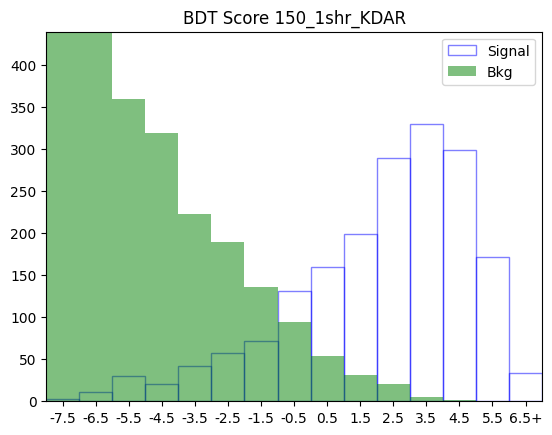

(1035,) (1035,)
(5020,) (5020,)


/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_92430/309311934.py:48: RuntimeWarning: divide by zero encountered in log
  return np.log(x/(1-x))


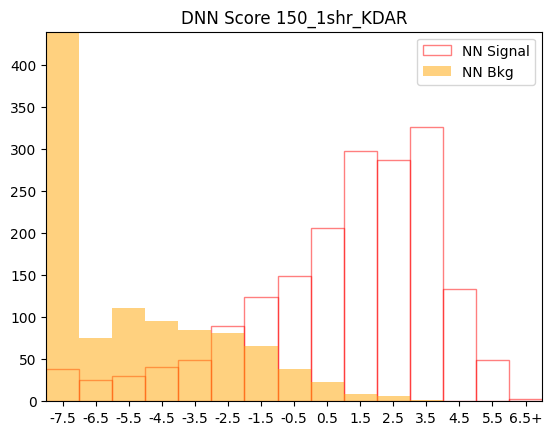

Making a cut at logit > -1.0
BDT
Purity = 0.8865903923714508
Efficiency Signal = 0.8725928658152352
Efficiency Background = 0.07063883289509461
NN:
Purity = 0.9501922320532806
Efficiency Signal = 0.7849601180321798
Efficiency Background = 0.026039834888496424
Updating KDAR scaling for signal
SUCCESSFULLY LOADED THE PICKLE FILES ('Run3', '200', '1shr', 'KDAR')
Number of signal events:  1028
Number of background events:  5020
(6048, 1) torch.Size([6048, 1])


/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_92430/3903234092.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bkg['label'] = 0


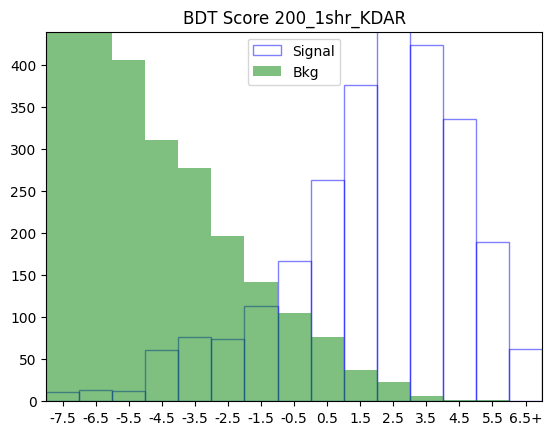

(1028,) (1028,)
(5020,) (5020,)


/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_92430/309311934.py:48: RuntimeWarning: divide by zero encountered in log
  return np.log(x/(1-x))


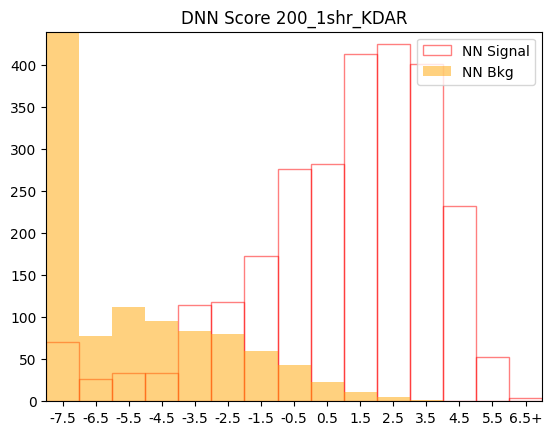

Making a cut at logit > -1.0
BDT
Purity = 0.9020795817162925
Efficiency Signal = 0.86366626382536
Efficiency Background = 0.08529612041092104
NN:
Purity = 0.9622889960471115
Efficiency Signal = 0.7853875690311911
Efficiency Background = 0.028002803529341157


In [235]:
Run = "3"
shr = "1shr"
kaon_prod = ["KDAR"]
masses = [100, 125, 130, 135, 140, 145, 150, 200]

get_TOF = False # Set to true to load time of flight values, used for the axion reweighting.
use_new_flux = False # Set to true to use the new (fixed) flux files. Currently only generated for Run3.
update_KDAR_scaling = True

scaler_used = scaler
net_used = net
plot_roc = False
plot_logit = True

for HPS_mass in masses:
    for K in kaon_prod:
        name = f"{HPS_mass}_{shr}_{K}"
        sig_arr, overlay_arr, dirt_arr, beamoff_arr, data_arr, detsys_arr, ov_detsys_arr = New_loader('Run'+Run, str(HPS_mass), shr, K, bool_full_sample=False, get_tof=get_TOF, for_david=False, testing_new_flux=use_new_flux, update_KDAR_scaling=update_KDAR_scaling)

        get_predictions(sig_arr, overlay_arr[::3], scaler_used, net, name, logit_cut=-1, show_confusion_roc=plot_roc, show_logit_comparison=plot_logit)



## Trying different input formats

In [7]:
filename = 'sfn_numi_rhc_generic_150_ppfx_CV_train.root'
root_tree = uproot.open(root_dir + 'Final_v51_FHC/'+filename)['nuselection/NeutrinoSelectionFilter']

In [23]:
tof_file = f"tof_fhc_100.root"
tree_temp = uproot.open(root_dir+"TOF_input_root/"+tof_file)

In [8]:
root_tree.keys()

['selected',
 'run',
 'sub',
 'evt',
 'trk_id',
 'shr_id',
 'trk2_id',
 'shr2_id',
 'shr_energy_tot',
 'shr_energy',
 'shr_energy_tot_cali',
 'shr_energy_cali',
 'shr_theta',
 'shr_phi',
 'shr_pca_0',
 'shr_pca_1',
 'shr_pca_2',
 'shr_px',
 'shr_py',
 'shr_pz',
 'shr_openangle',
 'shr_tkfit_start_x',
 'shr_tkfit_start_y',
 'shr_tkfit_start_z',
 'shr_tkfit_theta',
 'shr_tkfit_phi',
 'shr_start_x',
 'shr_start_y',
 'shr_start_z',
 'shr_dedx_Y',
 'shr_dedx_V',
 'shr_dedx_U',
 'shr_dedx_Y_cali',
 'shr_dedx_V_cali',
 'shr_dedx_U_cali',
 'shr_tkfit_dedx_Y',
 'shr_tkfit_dedx_V',
 'shr_tkfit_dedx_U',
 'shr_tkfit_dedx_max',
 'shr_tkfit_nhits_Y',
 'shr_tkfit_nhits_V',
 'shr_tkfit_nhits_U',
 'shr_llrpid_dedx_Y',
 'shr_llrpid_dedx_V',
 'shr_llrpid_dedx_U',
 'shr_llrpid_dedx',
 'shr_tkfit_dedx_Y_alt',
 'shr_tkfit_dedx_V_alt',
 'shr_tkfit_dedx_U_alt',
 'shr_tkfit_nhits_Y_alt',
 'shr_tkfit_nhits_V_alt',
 'shr_tkfit_nhits_U_alt',
 'trkfit',
 'shr_tkfit_npoints',
 'shr_tkfit_npointsvalid',
 'shr_trkfit

In [9]:
branch_id = ['reco_nu_vtx_x','reco_nu_vtx_y','reco_nu_vtx_z',
             
             ]

In [21]:
root_tree[''].array()

KeyInFileError: not found: 'tof'

    Available keys: 'pt', 'evt', 'p', 'trkfit', 'dvtx', 'dtrk', 'neta', 'run', 'sub', 'nu_pt', 'theta', 'nmuon', 'nproton', 'npion', 'eta_e', 'crtveto', 'pfpdg', 'trk_id', 'reco_e', 'true_p', 'ccnc', 'nu_e', 'nu_l', 'muon_e'...

in file /Users/user/PhD/HPS_uboone_analysis/Final_v51_FHC/sfn_numi_rhc_generic_150_ppfx_CV_train.root
in object /nuselection/NeutrinoSelectionFilter;1

In [10]:
shr_pca = root_tree['trk_start_x_v'].array(library='pd')
np.shape(shr_pca)

(46262,)

In [12]:
for entry in shr_pca.head():
    print(entry)

[64.7, 53]
[155]
[18.3, 17.6]
[]
[172]


(array([2.8819e+04, 3.7760e+03, 3.1060e+03, 2.6140e+03, 2.1300e+03,
        1.5310e+03, 1.1410e+03, 7.8300e+02, 5.7200e+02, 4.0600e+02,
        3.3300e+02, 2.3800e+02, 1.7100e+02, 1.3400e+02, 9.3000e+01,
        8.0000e+01, 6.9000e+01, 5.2000e+01, 4.7000e+01, 3.2000e+01,
        2.6000e+01, 1.5000e+01, 1.6000e+01, 1.4000e+01, 1.2000e+01,
        8.0000e+00, 6.0000e+00, 7.0000e+00, 8.0000e+00, 2.0000e+00,
        3.0000e+00, 4.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

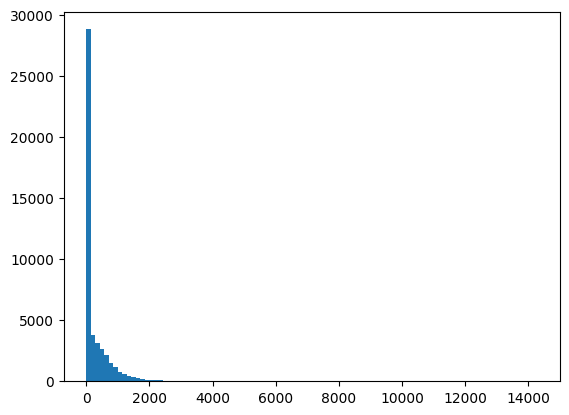

In [16]:
plt.hist(shr_pca, bins=100)

In [9]:
branches = root_tree.arrays(library='pd')

KeyboardInterrupt: 